In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# package
import os
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import rcParams,rc
import plotly
import plotly.graph_objs as go
import xarray as xr
import sys
import datetime
import pandas as pd
# script
from ncdf_io import ncdf_io
from regression import regress
from time_convert import time_convert, tarray_month
from Lambert_grid_on import *

### Greenland mass load 

In [4]:
dir1='/Users/joedhsu/Research/Rsync/Data_p/GRACE05_CSR/004_154/Greenland/'
file1='lmass.t60.s300.m.deg1.com004_154.GERUO_ICE5_COMP.ptcorr.nc'
file2='lmass.t60.s300.m.deg1.scaMB_decom_multi.com004_154.GERUO_ICE5_COMP.ptcorr.nc'
file3='slf.t60.s300.m.deg1.scaMB_decom_multi.com004_154.GERUO_ICE5_COMP.ptcorr.rf.nc'
files=[file1,file2]
outfile=['gisnoscale','gisscale','gisslf']

dir2='/Users/joedhsu/Research/Rsync/Data/Mask/Land_mask_v4/'
mfile2='land.fcn.1x1.1.0_deg_100KM2min_modi_greenland.nc'

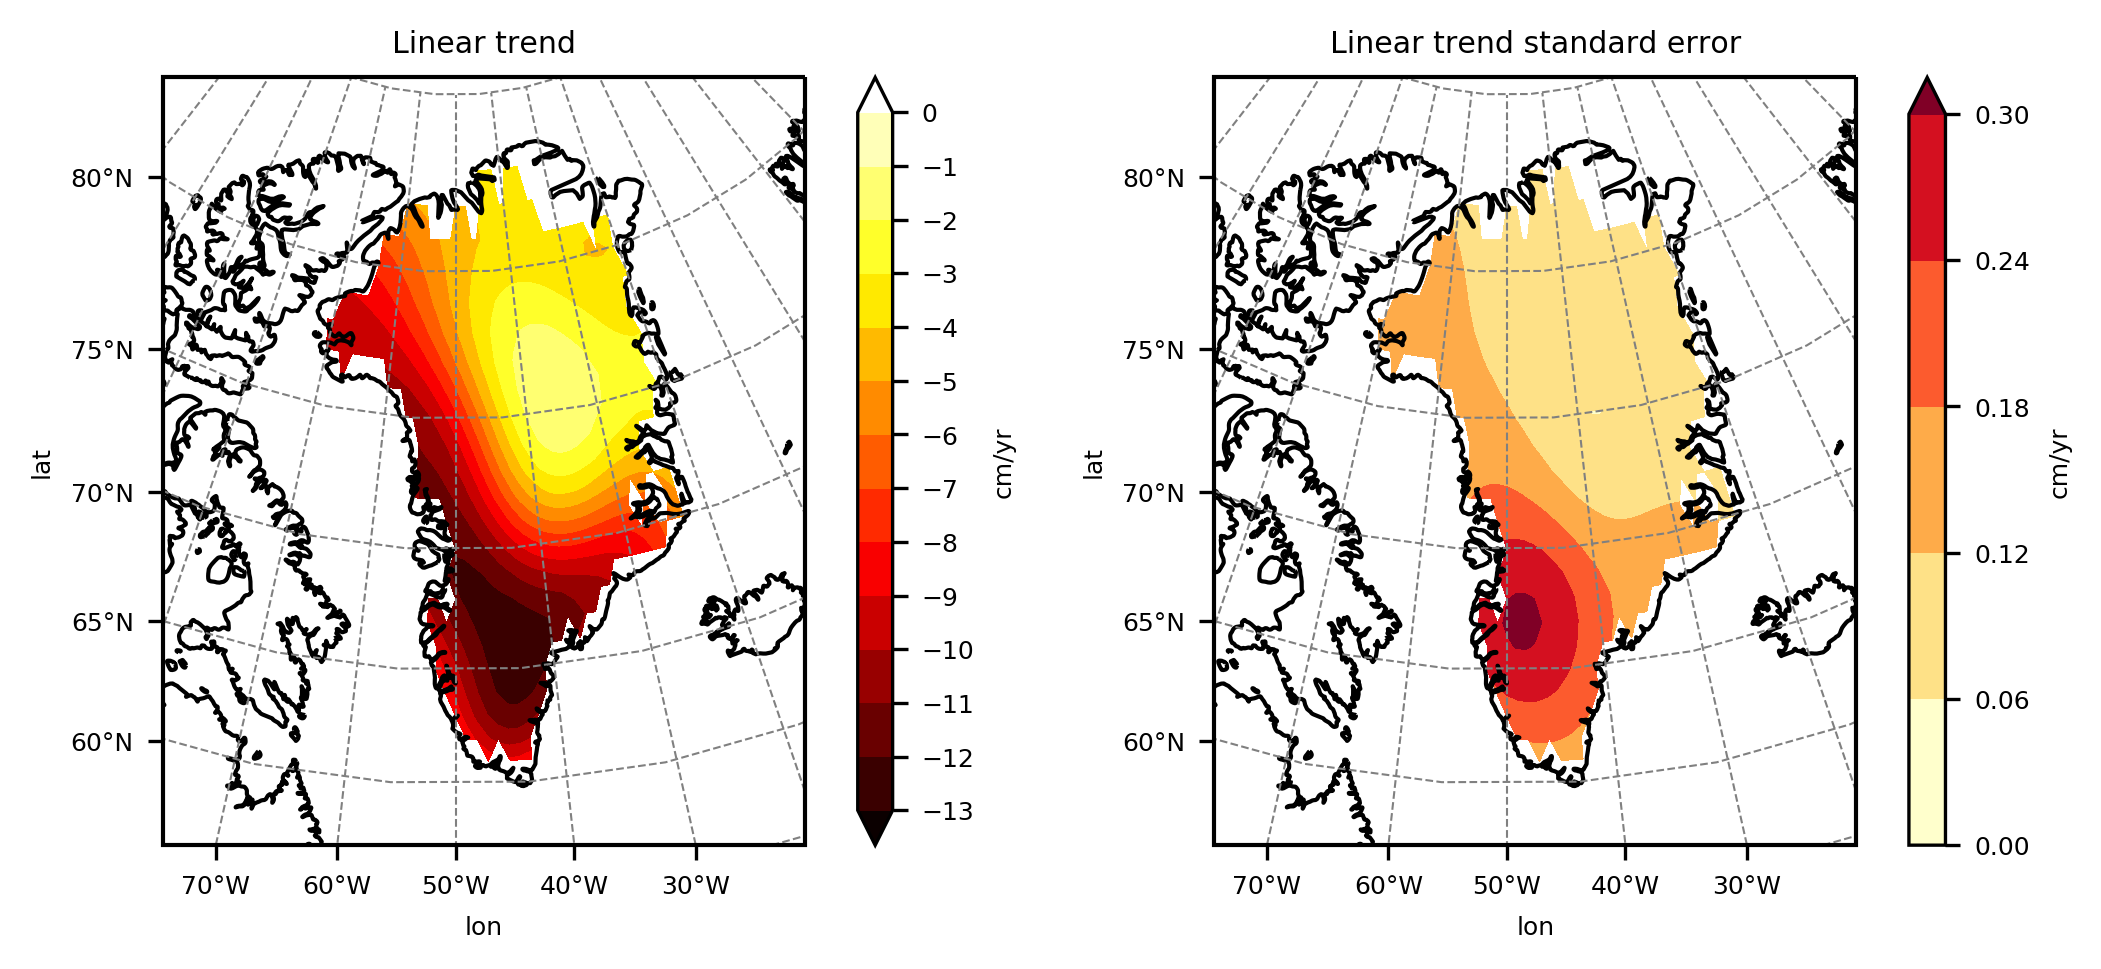

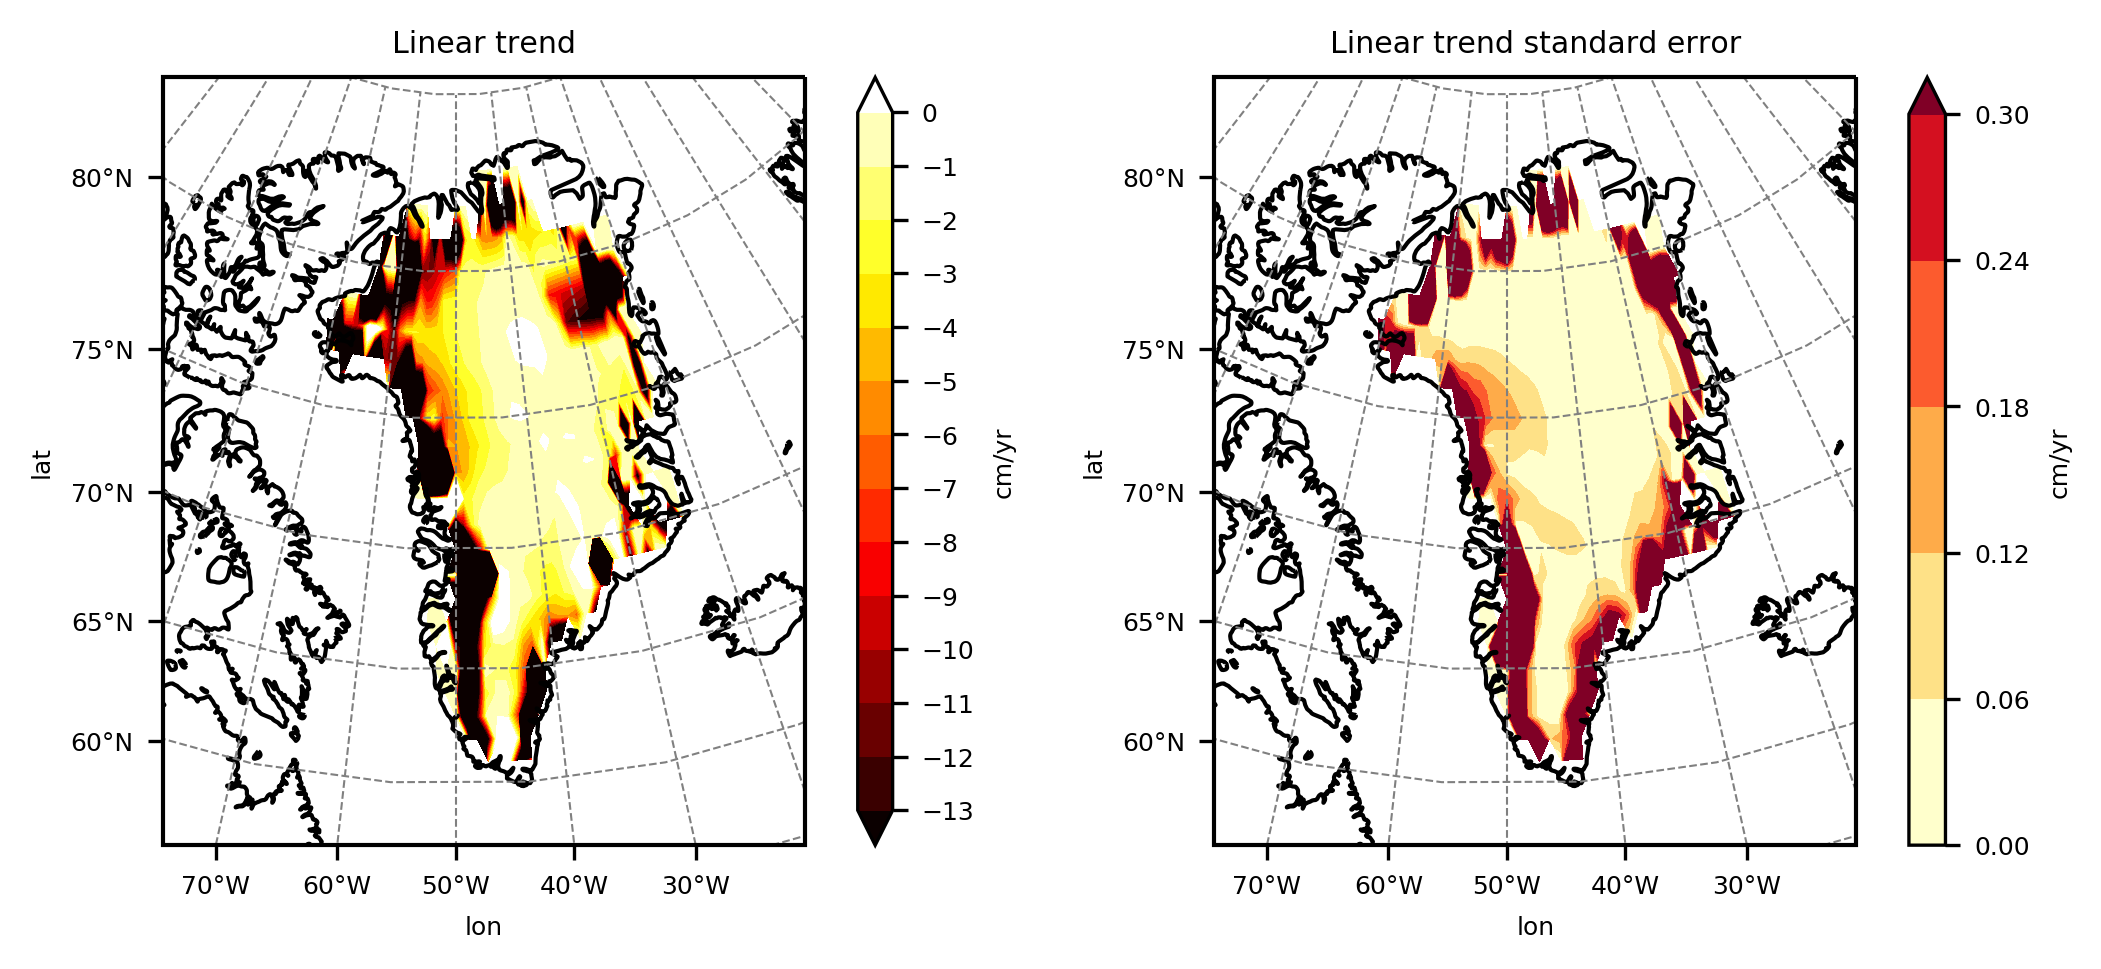

In [5]:
# read file 
gism=ncdf_io(dir2+mfile2,verbose=0)
dsm=gism.read_ncdf2xarray()

for i in range(len(files)): 
    # change the original axis from numpy array to pd.index
    gis=ncdf_io(dir1+files[i],verbose=0)
    ds=gis.read_ncdf2xarray()

    # old time stamp (change from np.array to pd.index)
    gmonth=np.array(ds['time'])+1   # start from 0 
    tdict=time_convert(gmonth).gmonth2year_mon()
    year=tdict['year']
    month=tdict['month']
    tstamp=pd.to_datetime([datetime.datetime(year[ii],month[ii],15) for ii in range(len(year))])

    # assign new time stamp
    ds['time']=xr.DataArray(tstamp,coords=[tstamp],dims=['time'])

    # masking the data 
    mask=dsm['z'].where(dsm>1E-10)['z']    # xr.Dataset to xr.Array
    ldata=ds['z']                          # xr.Dataset to xr.Array
    ldata=ldata*mask
    
    # make time array based on timestamp
    yeardate=time_convert(ds.time).tarray_month2year()

    #--- regression
    # the attribute "dm_order" is assigned after regression is performed once
    reg=regress(axis=yeardate)
    dict1=reg.multivar_regress(np.array(ldata.isel(lon=0,lat=0))
                                      ,predef_var='semisea_sea_lin')
    dimname=reg.dm_order
    # declare array size                           
    beta=np.zeros([ldata.lon.shape[0],ldata.lat.shape[0],len(dimname)])+np.nan
    se=np.zeros([ldata.lon.shape[0],ldata.lat.shape[0],len(dimname)])+np.nan   
    ds=xr.Dataset()
    for ii in range(len(ldata.lon)):
        for jj in range(len(ldata.lat)):
            if ~ldata.isel(lon=ii,lat=jj).sum(dim='time',skipna=False).isnull():
                dict1=reg.multivar_regress(np.array(ldata.isel(lon=ii,lat=jj))
                                          ,predef_var='semisea_sea_lin')
                beta[ii,jj,:]=dict1['beta']
                se[ii,jj,:]=dict1['se']

 
    # convert the data to xarray
    xr_beta=xr.DataArray(beta, coords=[ldata.lon,ldata.lat,dimname], 
                                 dims=['lon','lat','reg_variate'])
    xr_se=xr.DataArray(se, coords=[ldata.lon,ldata.lat,dimname], 
                         dims=['lon','lat','reg_variate'])

    # !!!!! must change the xarray dimension order to lat lon for plotting !!!!!!
    xr_beta=xr_beta.T  # for plotting must be lat lon
    xr_se=xr_se.T

    # combine xarray to dataset and output .nc file
    ds['beta']=xr_beta
    ds['se']=xr_se     
    ds.to_netcdf('./data/regress_'+outfile[i]+'.nc')


    # set the figure and data projection
    data_proj=ccrs.PlateCarree()
    # fig_proj=ccrs.Orthographic(-50, 45)    # rotating the center of the projection
    fig_proj = ccrs.LambertConformal(central_longitude=-50, central_latitude=45)
    # fig_proj = ccrs.Mercator(central_longitude=0.0, min_latitude=-80.0, max_latitude=84.0)

    # set the figure axes
    hmm=89.    # mm
    vmm=65.    # mm
    fontsize=6
    rcParams['xtick.direction'] = 'out'
    rcParams['ytick.direction'] = 'out'
    rcParams.update({'font.size': fontsize})
    rc('font', family='sans-serif')
    rc('font', serif='Helvetica')
    mm2inch=0.0393701
    hmm=hmm*mm2inch
    vmm=vmm*mm2inch
    fig=plt.figure(figsize=(hmm,vmm),dpi=300,facecolor='w',edgecolor='w')
    ax1=fig.add_axes([0,0,1,1],projection=fig_proj)
    ax2=fig.add_axes([1,0,1,1],projection=fig_proj)

    # plot the data in each axes
    plot1=ds['beta'].sel(reg_variate='lin').plot.contourf(ax=ax1, transform=data_proj
            , levels=np.linspace(-13,0,14), extend='both',cmap='hot'
            , cbar_kwargs={'ticks': np.linspace(-13,0,14),'label':'cm/yr'})
    ax1.set_title('Linear trend')
    ax1.set_extent([285,340,57,85], crs=data_proj)
    ax1.coastlines(resolution='50m')

    plot2=ds['se'].sel(reg_variate='lin').plot.contourf(ax=ax2, transform=data_proj
            , levels=np.linspace(0,0.30,6), extend='max',cmap='YlOrRd'
            , cbar_kwargs={'ticks': np.linspace(0,0.30,6),'label':'cm/yr'})
    ax2.set_title('Linear trend standard error')
    ax2.set_extent([285,340,57,85], crs=data_proj)
    ax2.coastlines(resolution='50m')

    ####################  Grid on  ######################
    # *must* call draw in order to get the axis boundary used to add ticks:
    fig.canvas.draw()
    xtick=np.linspace(0,360,37)-180.  # need to be -180~180
    ytick=np.linspace(55,85,7)

    # Label the end-points of the gridlines using the custom tick makers:
    ax1.gridlines(xlocs=xtick, ylocs=ytick,color='gray', linestyle='--', linewidth=0.5)
    ax1.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
    ax1.yaxis.set_major_formatter(LATITUDE_FORMATTER)
    lambert_xticks(ax1, xtick)
    lambert_yticks(ax1, ytick)

    ax2.gridlines(xlocs=xtick, ylocs=ytick,color='gray', linestyle='--', linewidth=0.5)
    ax2.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
    ax2.yaxis.set_major_formatter(LATITUDE_FORMATTER)
    lambert_xticks(ax2, xtick)
    lambert_yticks(ax2, ytick)


    # export the figure
    plt.savefig('./figures/regress_'+outfile[i]+'.pdf', dpi=300, facecolor='w', edgecolor='w',
            orientation='landscape', papertype=None, format=None,
            transparent=False, bbox_inches="tight", pad_inches=None,
            frameon=None)


               


            

### Greenland sea level fingerprint

In [6]:
dir1='/Users/joedhsu/Research/Rsync/Data_p/GRACE05_CSR/004_154/Greenland/'
file3='slf.t60.s300.m.deg1.scaMB_decom_multi.com004_154.GERUO_ICE5_COMP.ptcorr.rf.nc'
files=[file3]
outfile=['gisslf']

dir2='/Users/joedhsu/Research/Rsync/Data/Mask/Ocean_mask/Isabella/'
mfile2='ocn.pts.1_deg.nc'

In [7]:
# read file 
gism=ncdf_io(dir2+mfile2,verbose=0)
dsm=gism.read_ncdf2xarray()

for i in range(len(files)): 
    # change the original axis from numpy array to pd.index
    gis=ncdf_io(dir1+files[i],verbose=0)
    ds=gis.read_ncdf2xarray()

    # old time stamp (change from np.array to pd.index)
    gmonth=np.array(ds['time'])+1   # start from 0 
    tdict=time_convert(gmonth).gmonth2year_mon()
    year=tdict['year']
    month=tdict['month']
    tstamp=pd.to_datetime([datetime.datetime(year[ii],month[ii],15) for ii in range(len(year))])

    # assign new time stamp
    ds['time']=xr.DataArray(tstamp,coords=[tstamp],dims=['time'])

    # masking the data 
    mask=dsm['z'].where(dsm>1E-10)['z']    # xr.Dataset to xr.Array
    ldata=ds['z']                          # xr.Dataset to xr.Array
    ldata=ldata*mask
    
    # make time array based on timestamp
    yeardate=time_convert(ds.time).tarray_month2year()

    #--- regression
    # the attribute "dm_order" is assigned after regression is performed once
    reg=regress(axis=yeardate)
    dict1=reg.multivar_regress(np.array(ldata.isel(lon=0,lat=0))
                                      ,predef_var='semisea_sea_lin')
    dimname=reg.dm_order
    # declare array size                           
    beta=np.zeros([ldata.lon.shape[0],ldata.lat.shape[0],len(dimname)])+np.nan
    se=np.zeros([ldata.lon.shape[0],ldata.lat.shape[0],len(dimname)])+np.nan   
    ds=xr.Dataset()
    for ii in range(len(ldata.lon)):
        for jj in range(len(ldata.lat)):
            if ~ldata.isel(lon=ii,lat=jj).sum(dim='time',skipna=False).isnull():
                dict1=reg.multivar_regress(np.array(ldata.isel(lon=ii,lat=jj))
                                          ,predef_var='semisea_sea_lin')
                beta[ii,jj,:]=dict1['beta']
                se[ii,jj,:]=dict1['se']

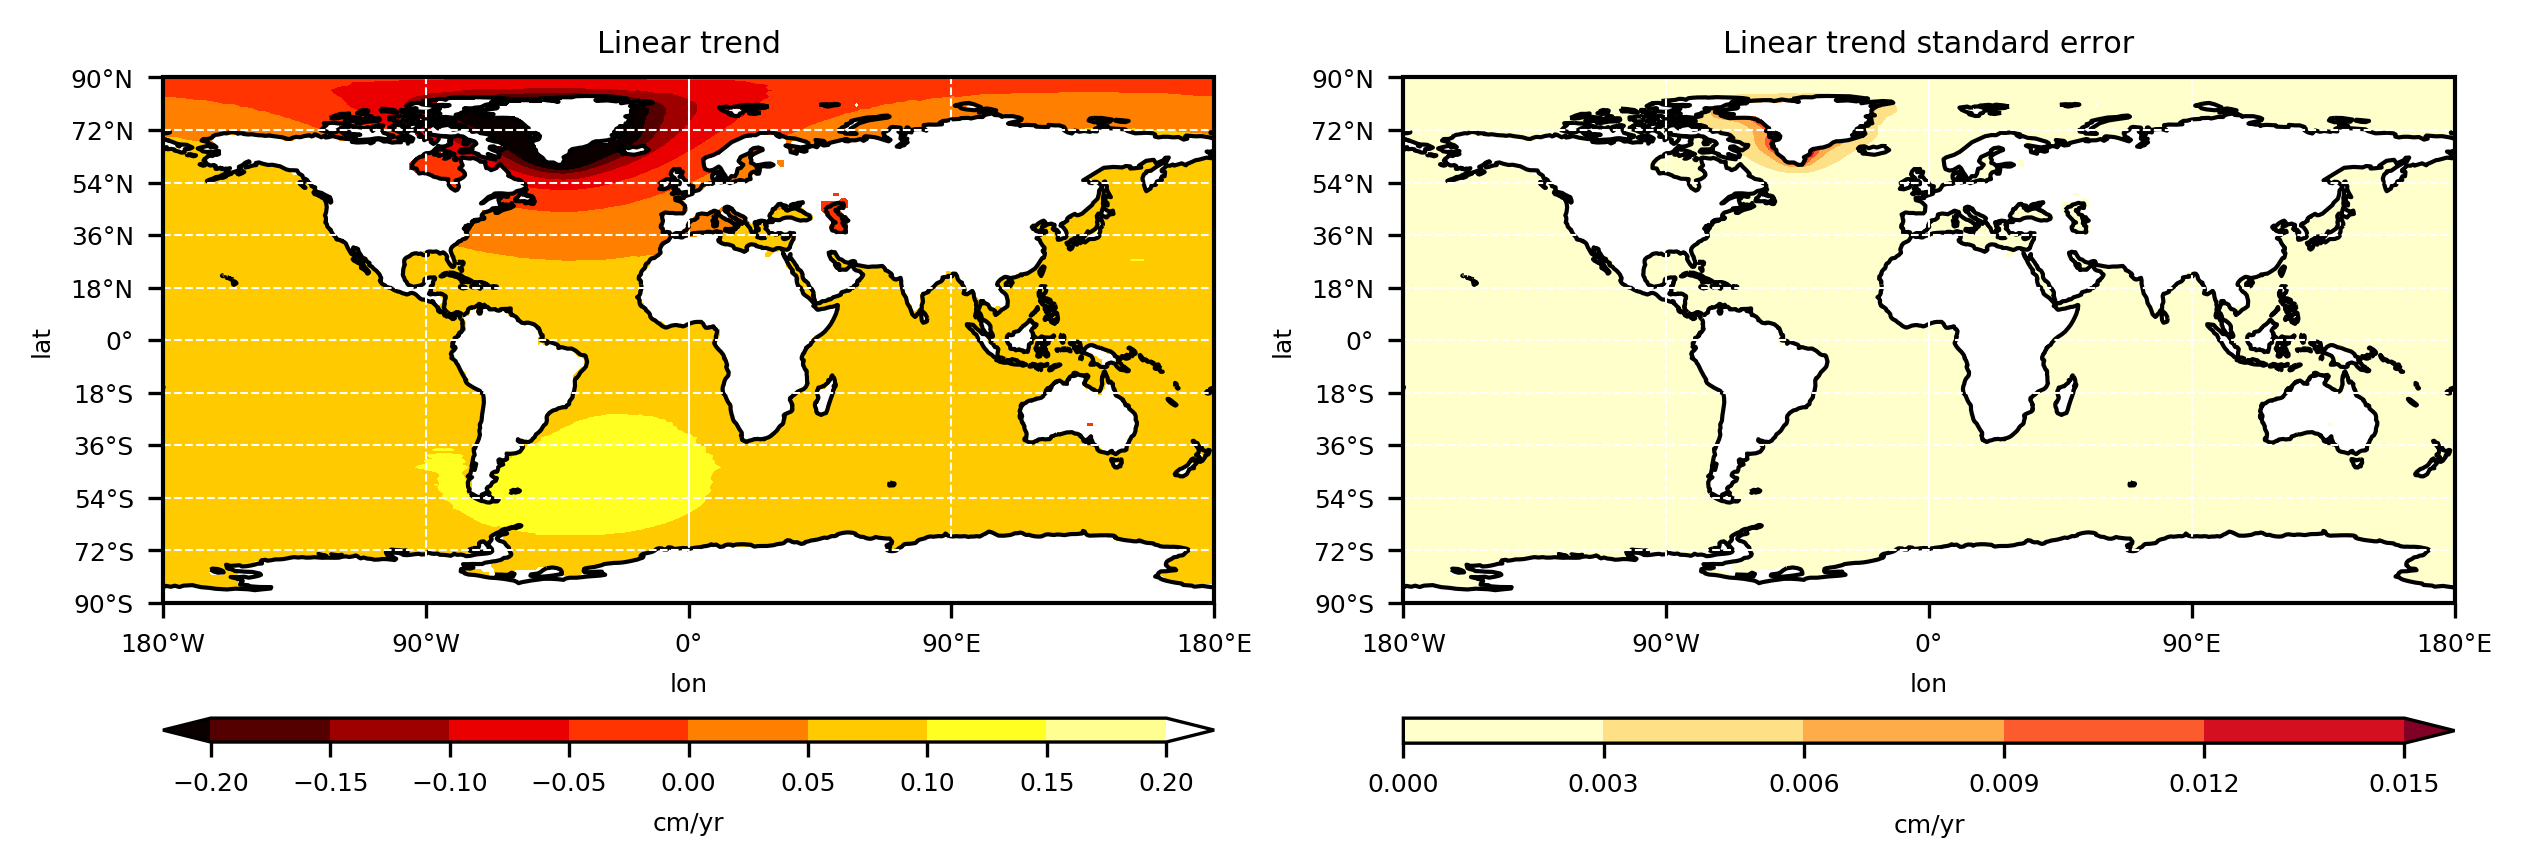

In [8]:
# convert the data to xarray
xr_beta=xr.DataArray(beta, coords=[ldata.lon,ldata.lat,dimname], 
                             dims=['lon','lat','reg_variate'])
xr_se=xr.DataArray(se, coords=[ldata.lon,ldata.lat,dimname], 
                     dims=['lon','lat','reg_variate'])

# !!!!! must change the xarray dimension order to lat lon for plotting !!!!!!
xr_beta=xr_beta.T  # for plotting must be lat lon
xr_se=xr_se.T

# combine xarray to dataset and output .nc file
ds['beta']=xr_beta
ds['se']=xr_se     
ds.to_netcdf('./data/regress_'+outfile[i]+'.nc')


# set the figure and data projection
data_proj=ccrs.PlateCarree()
# fig_proj=ccrs.Orthographic(-50, 45)    # rotating the center of the projection
#fig_proj = ccrs.LambertConformal(central_longitude=0, central_latitude=0)
#fig_proj = ccrs.Mercator(central_longitude=0.0, min_latitude=-80.0, max_latitude=84.0)
fig_proj=data_proj

# set the figure axes
hmm=89.    # mm
vmm=65.    # mm
fontsize=6
rcParams['xtick.direction'] = 'out'
rcParams['ytick.direction'] = 'out'
rcParams.update({'font.size': fontsize})
rc('font', family='sans-serif')
rc('font', serif='Helvetica')
mm2inch=0.0393701
hmm=hmm*mm2inch
vmm=vmm*mm2inch
fig=plt.figure(figsize=(hmm,vmm),dpi=300,facecolor='w',edgecolor='w')
ax1=fig.add_axes([0,0,1,1],projection=fig_proj)
ax2=fig.add_axes([1.18,0,1,1],projection=fig_proj)

# plot the data in each axes
plot1=ds['beta'].sel(reg_variate='lin').plot.contourf(ax=ax1, transform=data_proj
        , levels=np.linspace(-0.2,0.2,9), extend='both',cmap='hot'
        , cbar_kwargs={'ticks': np.linspace(-0.2,0.2,9),'label':'cm/yr'
                       ,'location':'bottom', 'aspect':40})
ax1.set_title('Linear trend')
# ax1.set_extent([285,340,57,85], crs=data_proj)
ax1.set_global()
ax1.coastlines()
    
plot2=ds['se'].sel(reg_variate='lin').plot.contourf(ax=ax2, transform=data_proj
        , levels=np.linspace(0,0.015,6)
        , extend='max',cmap='YlOrRd'
        , cbar_kwargs={'ticks': np.linspace(0,0.015,6),'label':'cm/yr'
                       ,'location':'bottom', 'aspect':40})
ax2.set_title('Linear trend standard error')
# ax2.set_extent([285,340,57,85], crs=data_proj)
# ax2.coastlines(resolution='50m')
ax2.set_global()
ax2.coastlines()

####################  Grid on  ######################
# *must* call draw in order to get the axis boundary used to add ticks:
fig.canvas.draw()
xtick=np.linspace(0,360,5)-180.  # need to be -180~180
ytick=np.linspace(-90,90,11)

# Label the end-points of the gridlines using the custom tick makers:
ax1.gridlines(xlocs=xtick, ylocs=ytick,color='w', linestyle='--', linewidth=0.5)
ax1.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax1.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax1, xtick)
lambert_yticks(ax1, ytick)

ax2.gridlines(xlocs=xtick, ylocs=ytick, color='w', linestyle='--', linewidth=0.5)
ax2.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax2.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax2, xtick)
lambert_yticks(ax2, ytick)


# export the figure
plt.savefig('./figures/regress_'+outfile[i]+'.pdf', dpi=300, facecolor='w', edgecolor='w',
        orientation='landscape', papertype=None, format=None,
        transparent=False, bbox_inches="tight", pad_inches=None,
        frameon=None)
